# Preparación del notebook

<a href="https://colab.research.google.com/github/rctejon/city-skating-regression/blob/master/rc.tejon-taller2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pandas-profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, ElasticNet
from sklearn.metrics import mean_squared_error, mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport

from cycler import cycler


# Descarga de a DB
plt.rcParams['figure.figsize'] = [15, 9]
sns.set(style="darkgrid")
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')

# Lectura de Datos

In [3]:
skate_df = pd.read_csv('https://raw.githubusercontent.com/rctejon/city-skating-regression/main/data/Data_Taller_2.csv', sep = ';')

# Utilidades

In [4]:
def histogram(attribute, lower, upper, bins, ylim = None, df=skate_df, serie=None):
  estate_serie = df[attribute]
  if serie is not None:
    estate_serie = serie
  estate_values = []
  for value in estate_serie:
    estate_values.append(value)

  plt.xlim(lower, upper)
  if ylim is not None:
     plt.ylim(0, ylim)
  sns.histplot(data=estate_values, color="skyblue", label = attribute, kde=True, bins = bins)

  plt.legend() 
  plt.show()

In [5]:
skate_df.shape

(731, 12)

In [6]:
skate_df.dtypes

instant        int64
Date          object
Season        object
Holiday       object
Weather       object
Temp          object
Feel_Temp     object
Hum           object
Wind          object
Casual         int64
Registered     int64
cnt            int64
dtype: object

In [7]:
skate_df.head(10)

instant        Date    Season Holiday               Weather       Temp  \
0        1   1/01/2020  Springer      No         Mist + Cloudy   8,175849   
1        2   2/01/2020  Springer      No         Mist + Cloudy   9,083466   
2        3   3/01/2020  Springer      No            Few clouds   1,229108   
3        4   4/01/2020  Springer      No            Few clouds        1,4   
4        5   5/01/2020  Springer      No      Partly    cloudy   2,666979   
5        6   6/01/2020  Springer      No                 Clear   1,604356   
6        7   7/01/2020  Springer      No                  Mist   1,236534   
7        8   8/01/2020  Springer      No  Mist + Broken clouds     -0,245   
8        9   9/01/2020  Springer      No         Partly cloudy  -1,498349   
9       10  10/01/2020  Springer      No      Partly    cloudy  -0,910849   

   Feel_Temp       Hum        Wind  Casual  Registered   cnt  
0   9,090375  0,805833   10,749882     331         654   985  
1   8,625733  0,696087  -16,652113     131         670   801  
2   0,902035  0,437273   16,636703     120        1229  1349  
3   1,969734  0,590435   10,739832     108        1454  1562  
4    2,77569  0,436957     12,5223      82        1518  1600  
5   2,960823  0,518261   6,0008684      88        1518  1606  
6   1,815433  0,498696   11,304642     148        1362  1510  
7  -0,374062  0,535833   17,875868      68         891   959  
8  -2,539775  0,434167    24,25065      54         768   822  
9  -0,908264  0,482917   14,958889      41        1280  1321

# Limpieza Basica



*   Se pasara todo a minuscula para evitar duplicados en las columnas categoricas.
*   Se eliminaran espacios al inicio y al final.
*   Se castearon elementos que eran String a String en las columnas que deben ser flotantes.


In [8]:
# Para iniciar con la limpieza se pasaron todos las campos de texto a minusculas y se quitaron cualquier espacio que pueda tener
skate_df['Season'] = skate_df['Season'].str.lower()
skate_df['Season'] = skate_df['Season'].str.strip()
skate_df['Weather'] = skate_df['Weather'].str.lower()
skate_df['Weather'] = skate_df['Weather'].str.strip()
skate_df['Holiday'] = skate_df['Holiday'].str.lower()
skate_df['Holiday'] = skate_df['Holiday'].str.strip()

In [9]:
# Se convierte las columnas con precios de texto a flotante
def str_to_float(x):
    if isinstance(x, float):
      return x
    x = x.replace(',', '.') 
    return float(x.strip())

skate_df['Temp'] = skate_df['Temp'].apply(str_to_float)
skate_df['Feel_Temp'] = skate_df['Feel_Temp'].apply(str_to_float)
skate_df['Hum'] = skate_df['Hum'].apply(str_to_float)
skate_df['Wind'] = skate_df['Wind'].apply(str_to_float)

In [10]:
skate_df.dtypes

instant         int64
Date           object
Season         object
Holiday        object
Weather        object
Temp          float64
Feel_Temp     float64
Hum           float64
Wind          float64
Casual          int64
Registered      int64
cnt             int64
dtype: object

# Perfilación de datos

In [11]:
profile_history = ProfileReport(skate_df)
profile_history.to_notebook_iframe()
profile_history.to_file('report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

En esta perfilación de los datos no se encontraron duplicados ni ningun otro problema a nivel de tabla o fila.

In [12]:
skate_df.isnull().any()

instant       False
Date          False
Season        False
Holiday       False
Weather       False
Temp           True
Feel_Temp     False
Hum           False
Wind          False
Casual        False
Registered    False
cnt           False
dtype: bool

A nivel de columna se puede observar que la unica columna con elementso nulos es `Temp` lo cual se corregira posteriormente.

In [13]:
skate_df.head(10)

instant        Date    Season Holiday               Weather      Temp  \
0        1   1/01/2020  springer      no         mist + cloudy  8.175849   
1        2   2/01/2020  springer      no         mist + cloudy  9.083466   
2        3   3/01/2020  springer      no            few clouds  1.229108   
3        4   4/01/2020  springer      no            few clouds  1.400000   
4        5   5/01/2020  springer      no      partly    cloudy  2.666979   
5        6   6/01/2020  springer      no                 clear  1.604356   
6        7   7/01/2020  springer      no                  mist  1.236534   
7        8   8/01/2020  springer      no  mist + broken clouds -0.245000   
8        9   9/01/2020  springer      no         partly cloudy -1.498349   
9       10  10/01/2020  springer      no      partly    cloudy -0.910849   

   Feel_Temp       Hum       Wind  Casual  Registered   cnt  
0   9.090375  0.805833  10.749882     331         654   985  
1   8.625733  0.696087 -16.652113     131         670   801  
2   0.902035  0.437273  16.636703     120        1229  1349  
3   1.969734  0.590435  10.739832     108        1454  1562  
4   2.775690  0.436957  12.522300      82        1518  1600  
5   2.960823  0.518261   6.000868      88        1518  1606  
6   1.815433  0.498696  11.304642     148        1362  1510  
7  -0.374062  0.535833  17.875868      68         891   959  
8  -2.539775  0.434167  24.250650      54         768   822  
9  -0.908264  0.482917  14.958889      41        1280  1321

# Limpieza, analisis univariado y transformaciones para regresión por atributo 

En esta sección se haran las limpiezas a nivel de columna; analisis univariados de cada columna y por ultimo, se haran transformaciones a los datos con los que se probara en la creación de los modelos.

In [14]:
skate_df.columns

Index(['instant', 'Date', 'Season', 'Holiday', 'Weather', 'Temp', 'Feel_Temp',
       'Hum', 'Wind', 'Casual', 'Registered', 'cnt'],
      dtype='object')

## Estaciones

In [15]:
seasons = skate_df['Season'].unique()
seasons

array(['springer', 'summer', 'fall', 'winter'], dtype=object)

Se observa que no existe problema a nivel de columna ni atributo, pero al ser una variable categorica toca transformarla en valores numericos, debido a que estn en un orden lógico, se puede hacer un ciclo sobre esta lista.

In [16]:
for i, season in enumerate(seasons):
  skate_df['Season'] = skate_df['Season'].replace(season, i)

Ademas de esto debido a que las estaciones son algo ciclico se pueden representar en un circulo unitario, se calcularan las coordenadas Y y X de la siguiente representación de las estaciones. Esto se calculara utilizando las propiedades de seno y coseno.

<img src="https://raw.githubusercontent.com/rctejon/city-skating-regression/main/images/Seasons_cycle.jpeg" height = 400px> 

In [17]:
def season_x(x):
  return np.sin((x * 2 * np.pi) / 4)
skate_df['Season_X'] = skate_df['Season'].apply(season_x)

In [18]:
def season_y(y):
  return np.cos((y * 2 * np.pi) / 4)
skate_df['Season_Y'] = skate_df['Season'].apply(season_y)

## Festivos

In [19]:
holidays = skate_df['Holiday'].unique()
holidays

array(['no', 'yes'], dtype=object)

Se observa que no existe problema a nivel de columna ni atributo, pero al ser una variable categorica toca transformarla en valores numericos, debido a que estn en un orden lógico, se puede hacer un ciclo sobre esta lista.

In [20]:
skate_df['Holiday'] = skate_df['Holiday'].replace('no', -1)
skate_df['Holiday'] = skate_df['Holiday'].replace('yes', 1)

Se pasaron los valores positivos a 1 y negativos a -1

## Clima

In [21]:
weathers = skate_df['Weather'].unique()
weathers

array(['mist + cloudy', 'few clouds', 'partly    cloudy', 'clear', 'mist',
       'mist + broken clouds', 'partly cloudy', 'mist + few clouds',
       'rain + thunderstorm', 'light rain + scattered clouds', 'snow'],
      dtype=object)

Se observa la existencia de unos sinonimos `'partly----cloudy'` y `'partly-cloudy'`

In [22]:
skate_df['Weather'] = skate_df['Weather'].replace('partly    cloudy', 'partly cloudy')

In [23]:
skate_df['Weather'] = skate_df['Weather'].replace('clear', -1)
skate_df['Weather'] = skate_df['Weather'].replace('few clouds', -1)
skate_df['Weather'] = skate_df['Weather'].replace('partly cloudy', -1)
skate_df['Weather'] = skate_df['Weather'].replace('mist', 1)
skate_df['Weather'] = skate_df['Weather'].replace('mist + cloudy', 1)
skate_df['Weather'] = skate_df['Weather'].replace('mist + few clouds', 1)
skate_df['Weather'] = skate_df['Weather'].replace('mist + broken clouds', 1)
skate_df['Weather'] = skate_df['Weather'].replace('light rain + scattered clouds', 10)
skate_df['Weather'] = skate_df['Weather'].replace('rain + thunderstorm', 10)
skate_df['Weather'] = skate_df['Weather'].replace('snow', 10)

Se mapean todos las catgorias que se refieran a precipitaciones a 10, las que tengan neblina a 1 y las demas a -1, como fue indicado por el experto.

## Temperatura


In [24]:
temp_serie = skate_df['Temp']
min_temp = temp_serie.quantile(0)
median_temp = temp_serie.quantile(0.5)
average_temp = temp_serie.mean()
max_temp = temp_serie.quantile(1)
print(f'Min: {min_temp} Median: {median_temp} Average: {average_temp} Max : {max_temp}')

Min: -5.2208712 Median: 15.421651 Average: 15.271062831911967 Max : 32.498349


Debido a que la temperatura es la unica que tiene valores nulos se reemplazaran con el promedio, para no alterar tanto el modelo con casos dañados.

In [25]:
skate_df['Temp'] = skate_df['Temp'].fillna(15.271062831911967)

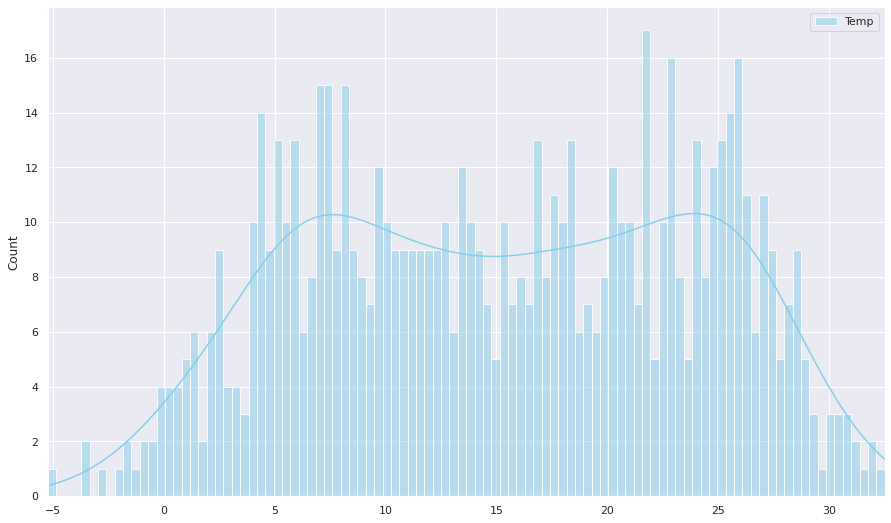

In [26]:
histogram('Temp', min_temp, max_temp, 100)

En esta columna tiene sentido hacer una normalización para que los valores vayan de 0 a 1. 


In [27]:
skate_df['Temp_new']=(skate_df['Temp']-skate_df['Temp'].min())/(skate_df['Temp'].max()-skate_df['Temp'].min())

In [28]:
temp_serie = skate_df['Temp_new']
min_temp = temp_serie.quantile(0)
median_temp = temp_serie.quantile(0.5)
average_temp = temp_serie.mean()
max_temp = temp_serie.quantile(1)
print(f'Min: {min_temp} Median: {median_temp} Average: {average_temp} Max : {max_temp}')

Min: 0.0 Median: 0.543275654248864 Average: 0.543275654248864 Max : 1.0


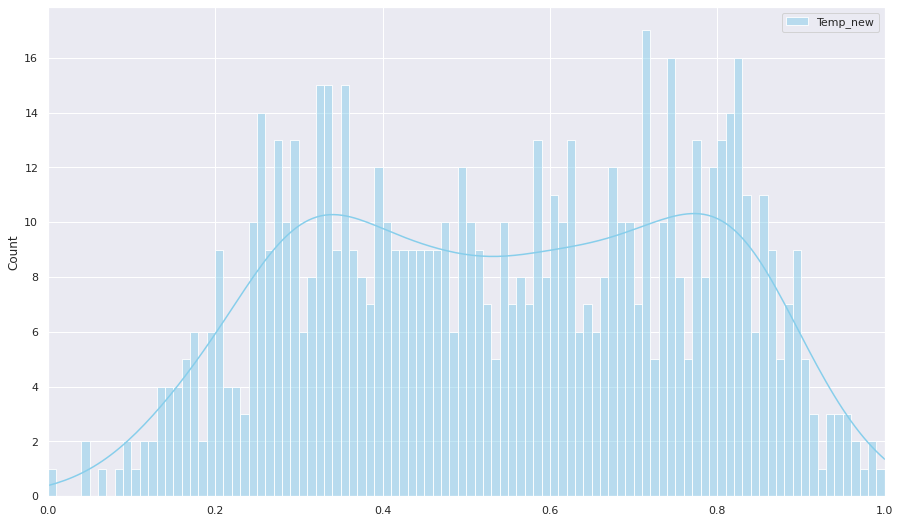

In [29]:
histogram('Temp_new', min_temp, max_temp, 100)

## Sensación Termica


In [30]:
feel_temp_serie = skate_df['Feel_Temp']
min_feel_temp = feel_temp_serie.quantile(0)
median_feel_temp = feel_temp_serie.quantile(0.5)
average_feel_temp = feel_temp_serie.mean()
max_feel_temp = feel_temp_serie.quantile(1)
print(f'Min: {min_feel_temp} Median: {median_feel_temp} Average: {average_feel_temp} Max : {max_feel_temp}')

Min: -4.2837288 Median: 14.876451 Average: 14.294637466347469 Max : 31.522112


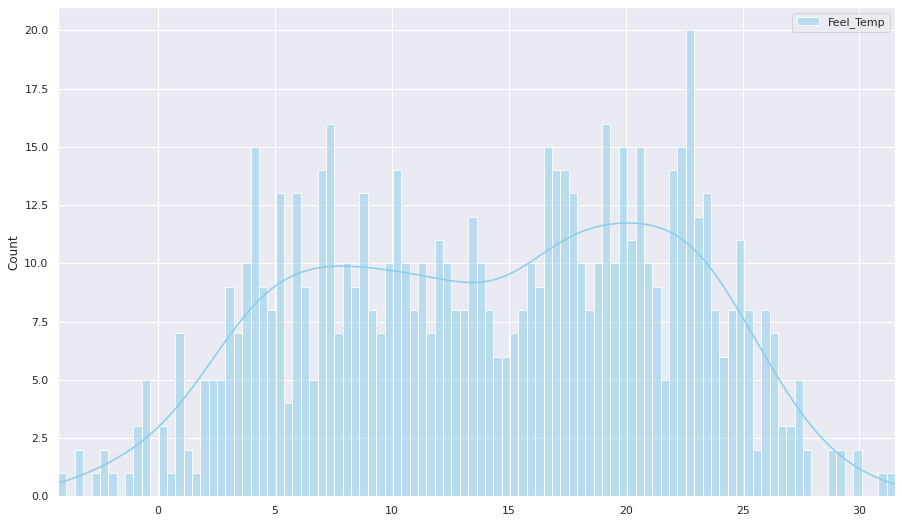

In [31]:
histogram('Feel_Temp', min_feel_temp, max_feel_temp, 100)

En esta columna tiene sentido hacer una normalización para que los valores vayan de 0 a 1. 


In [32]:
skate_df['Feel_Temp_new']=(skate_df['Feel_Temp']-skate_df['Feel_Temp'].min())/(skate_df['Feel_Temp'].max()-skate_df['Feel_Temp'].min())

In [33]:
feel_temp_serie = skate_df['Feel_Temp_new']
min_feel_temp = feel_temp_serie.quantile(0)
median_feel_temp = feel_temp_serie.quantile(0.5)
average_feel_temp = feel_temp_serie.mean()
max_feel_temp = feel_temp_serie.quantile(1)
print(f'Min: {min_feel_temp} Median: {median_feel_temp} Average: {average_feel_temp} Max : {max_feel_temp}')

Min: 0.0 Median: 0.5351132488976491 Average: 0.5188641252727535 Max : 1.0


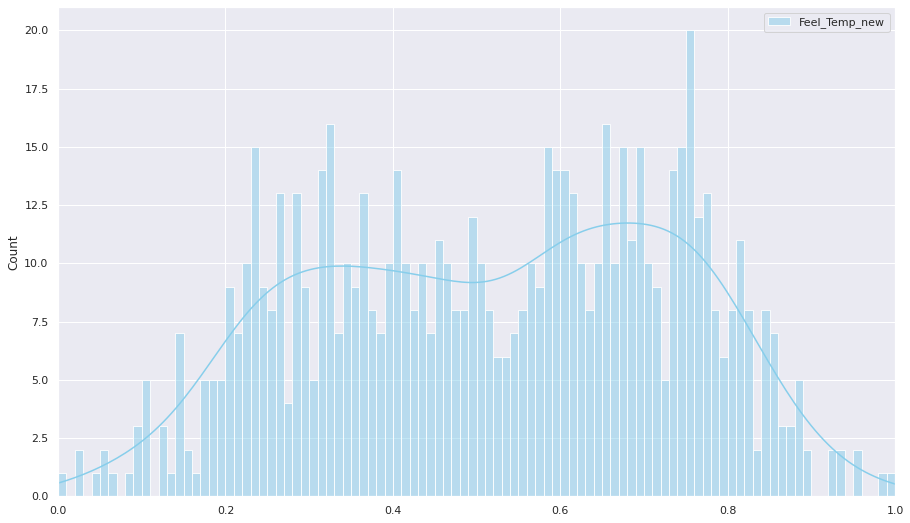

In [34]:
histogram('Feel_Temp_new', min_feel_temp, max_feel_temp, 100)

## Viento


In [35]:
wind_serie = skate_df['Wind']
min_wind = wind_serie.quantile(0)
median_wind = wind_serie.quantile(0.5)
average_wind = wind_serie.mean()
max_wind = wind_serie.quantile(1)
print(f'Min: {min_wind} Median: {median_wind} Average: {average_wind} Max : {max_wind}')

Min: -16.652113 Median: 12.124789 Average: 12.668791980437758 Max : 34.000021


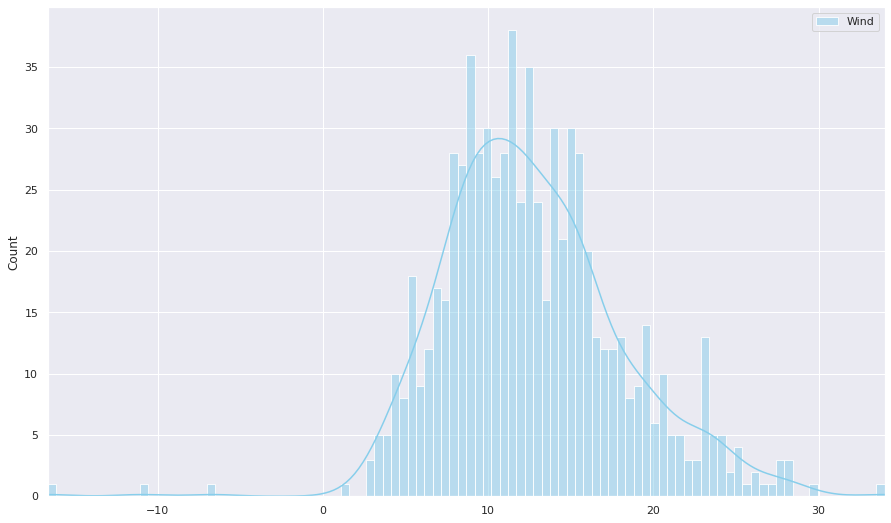

In [36]:
histogram('Wind', min_wind, max_wind, 100)

En esta columna tiene sentido hacer una normalización para que los valores vayan de 0 a 1. 


In [37]:
skate_df['Wind_new']=(skate_df['Wind']-skate_df['Wind'].min())/(skate_df['Wind'].max()-skate_df['Wind'].min())

In [38]:
wind_serie = skate_df['Wind_new']
min_wind = wind_serie.quantile(0)
median_wind = wind_serie.quantile(0.5)
average_wind = wind_serie.mean()
max_wind = wind_serie.quantile(1)
print(f'Min: {min_wind} Median: {median_wind} Average: {average_wind} Max : {max_wind}')

Min: 0.0 Median: 0.5681281266451677 Average: 0.5788681081124393 Max : 1.0


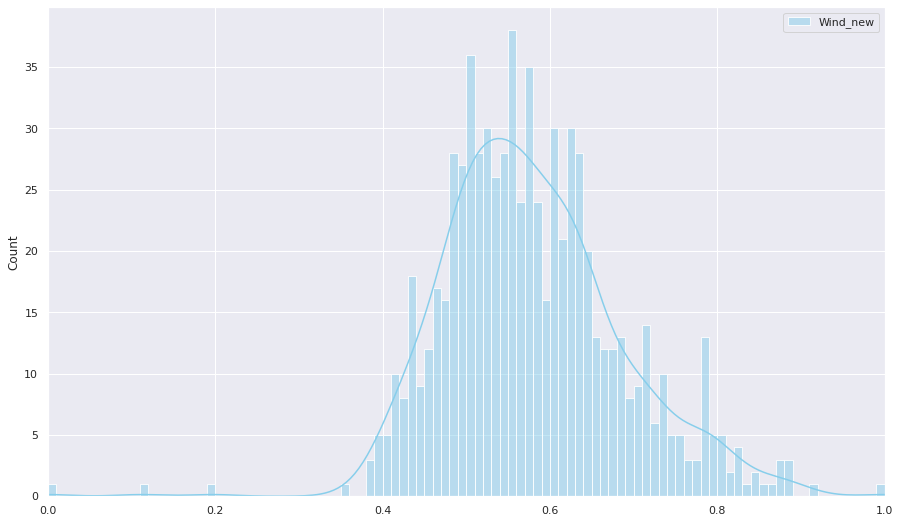

In [39]:
histogram('Wind_new', min_wind, max_wind, 100)

## Humedad


In [40]:
hum_serie = skate_df['Hum']
min_hum = hum_serie.quantile(0)
median_hum = hum_serie.quantile(0.5)
average_hum = hum_serie.mean()
max_hum = hum_serie.quantile(1)
print(f'Min: {min_hum} Median: {median_hum} Average: {average_hum} Max : {max_hum}')

Min: 0.0 Median: 0.629167 Average: 0.6826136251709987 Max : 10.867083


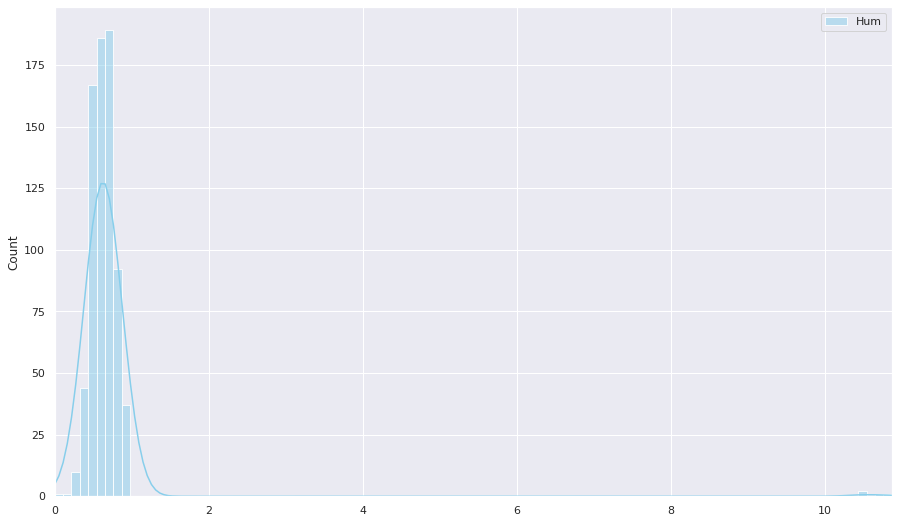

In [41]:
histogram('Hum', min_hum, max_hum, 100)

En esta columna se supone que los valores ya estan normalizados, pero se puede ver que no es asi debido a que existen unos cuantos valores mayores a 1, se acotara para que todos los elementos esten entre 0 y 1.

In [42]:
skate_df['Hum_new'] = skate_df['Hum'].clip(0, 1)

In [43]:
hum_serie = skate_df['Hum_new']
min_hum = hum_serie.quantile(0)
median_hum = hum_serie.quantile(0.5)
average_hum = hum_serie.mean()
max_hum = hum_serie.quantile(1)
print(f'Min: {min_hum} Median: {median_hum} Average: {average_hum} Max : {max_hum}')

Min: 0.0 Median: 0.629167 Average: 0.6300157592339262 Max : 1.0


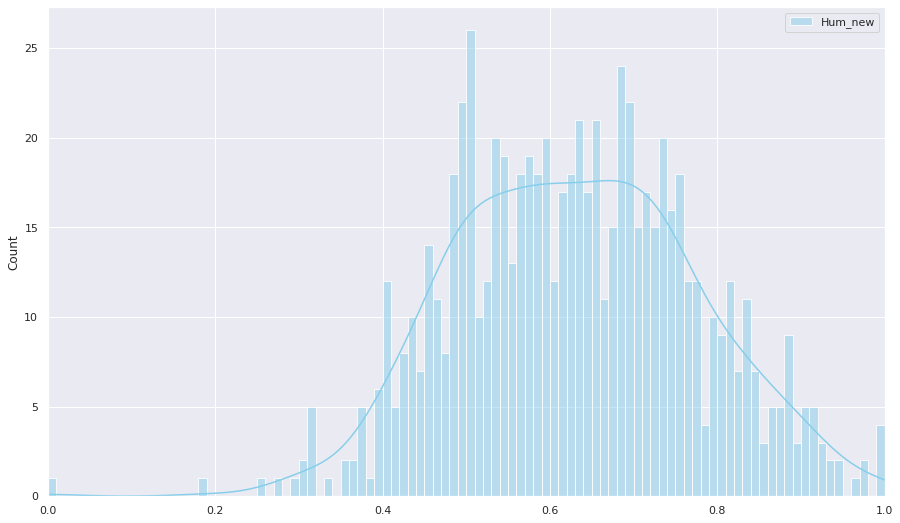

In [44]:
histogram('Hum_new', min_hum, max_hum, 100)

## Variables objetivo

### Usuarios Registrados


In [45]:
cnt_serie = skate_df['cnt']
min_cnt = cnt_serie.quantile(0)
median_cnt = cnt_serie.quantile(0.5)
average_cnt = cnt_serie.mean()
max_cnt = cnt_serie.quantile(1)
print(f'Min: {min_cnt} Median: {median_cnt} Average: {average_cnt} Max : {max_cnt}')

Min: 22.0 Median: 4548.0 Average: 4504.3488372093025 Max : 8714.0


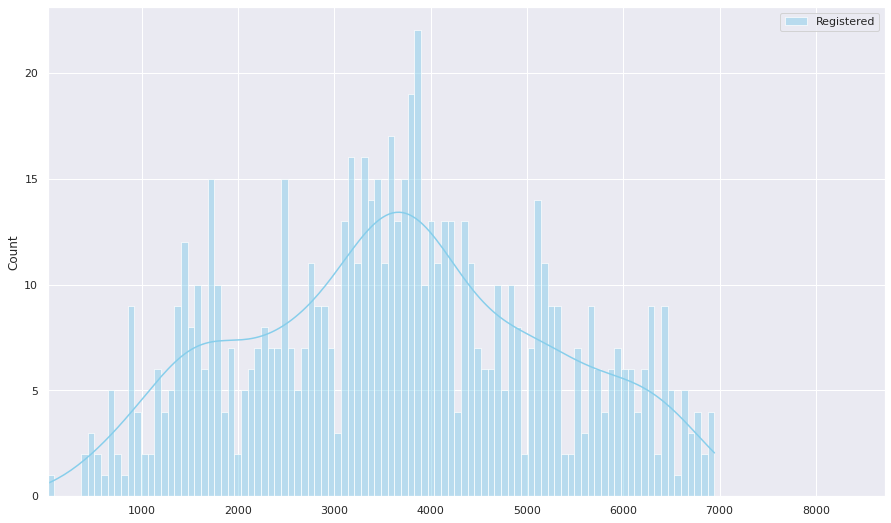

In [46]:
histogram('Registered', min_cnt, max_cnt, 100)

In [47]:
skate_df['cnt'].equals(skate_df['Casual'] + skate_df['Registered'])

True

Se puede observar que el conteo es una combinación lineal de los usuarios registrados y los usuarios casuales. por lo que no tiene sentido utilizarlos en el modelo, puesto que si uno tiene estos datos ya consigue la variable objetivo por lo cual se tomaran estos 2 columnas como el objetivo del modelo.

### Usuarios Casuales


In [48]:
casual_serie = skate_df['Casual']
min_casual = casual_serie.quantile(0)
median_casual = casual_serie.quantile(0.5)
average_casual = casual_serie.mean()
max_casual = casual_serie.quantile(1)
print(f'Min: {min_casual} Median: {median_casual} Average: {average_casual} Max : {max_casual}')

Min: 2.0 Median: 713.0 Average: 848.1764705882352 Max : 3410.0


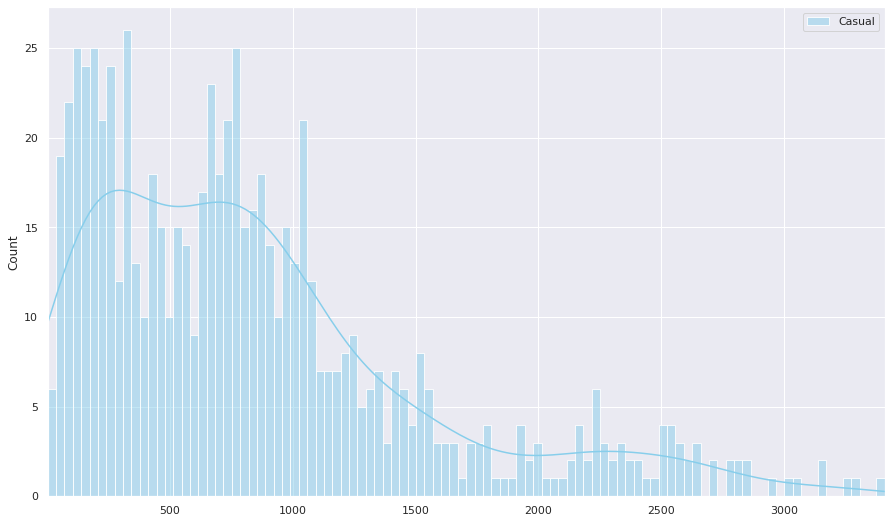

In [49]:
histogram('Casual', min_casual, max_casual, 100)

### Usuarios Registrados


In [50]:
registered_serie = skate_df['Registered']
min_registered = registered_serie.quantile(0)
median_registered = registered_serie.quantile(0.5)
average_registered = registered_serie.mean()
max_registered = registered_serie.quantile(1)
print(f'Min: {min_registered} Median: {median_registered} Average: {average_registered} Max : {max_registered}')

Min: 20.0 Median: 3662.0 Average: 3656.172366621067 Max : 6946.0


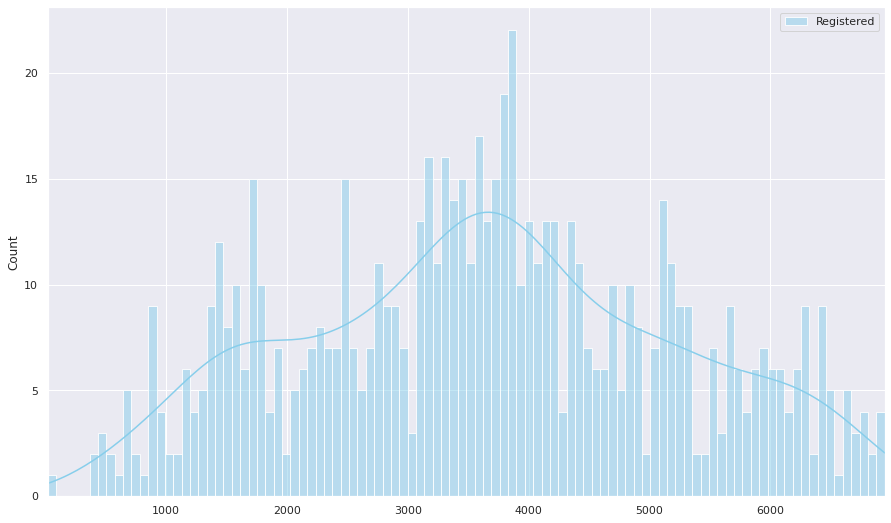

In [51]:
histogram('Registered', min_registered, max_registered, 100)

## Analisis Bivariado

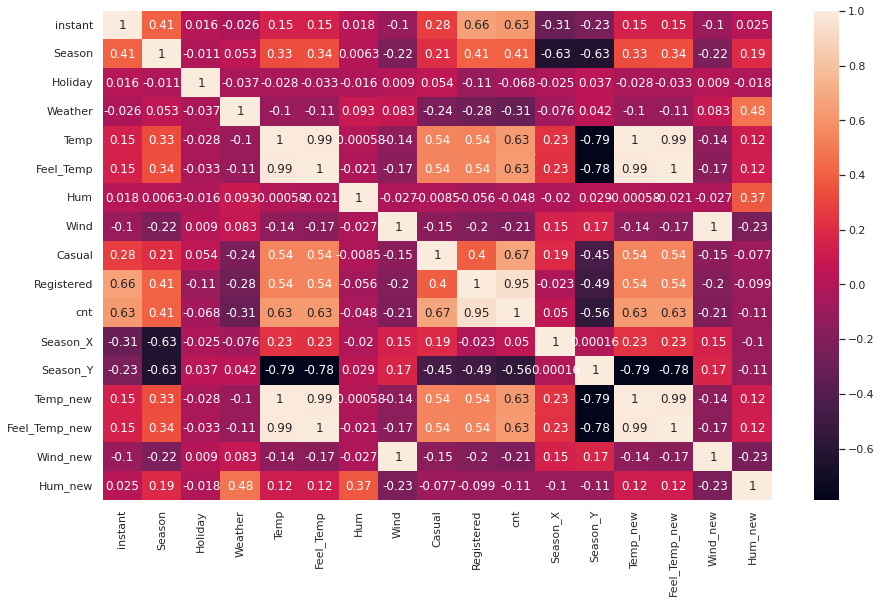

In [52]:
corrMatrix = skate_df.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

En este mapa de color se puede concluir que para la variable objetivo:


1.   **Casual**: Las unicas variables independientes antes de transformaciónes con correlación mayor a 0.4 o menor -0.4 son la temperatura y la sensación termica, en cuanto a las transformaciones se ve una correlación alta con Season_Y, la sensasión termica y la temperatura normalizadas. 
2.   **Registered**: Para los usuarios registrados se encuentra que las mismas variables son las que tienen las correlaciones de mayor magnitud, aunque en este caso la estación tambien cuenta con una magnitud alta.


# Modelo


## Variables

In [53]:
skate_df.columns

Index(['instant', 'Date', 'Season', 'Holiday', 'Weather', 'Temp', 'Feel_Temp',
       'Hum', 'Wind', 'Casual', 'Registered', 'cnt', 'Season_X', 'Season_Y',
       'Temp_new', 'Feel_Temp_new', 'Wind_new', 'Hum_new'],
      dtype='object')

Para iniciar se probara una regresión lineal con las variables precvio a transformaciones.

In [54]:
features = ['Season', 'Holiday', 'Weather', 'Temp', 'Feel_Temp', 'Hum', 'Wind']

Las variables objetivo son Usuarios Casuales y Usuarios Registrados debido a que el conteo de todos los usuarios, es solo la suma de estos 2 y esto nos puede dar una información extra que a la larga puede ser util.

In [55]:
objectives = ['Casual', 'Registered']

## Dividiendo el dataset en entrenamiento y prueba


In [56]:
X = skate_df[features]
Y = skate_df[objectives]

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 118273091)

In [58]:
X_train.shape

(511, 7)

In [59]:
X_test.shape

(220, 7)

### Entrenamiento

Para iniciar se utilizara un modelo de regresión lineal con los parametros por defecto.

In [60]:
regr = LinearRegression()

In [61]:
regr.fit(X_train, Y_train)

LinearRegression()

In [62]:
regr.coef_

array([[  16.21209876,  136.76582013,  -74.38084533,   28.48916026,
          14.27873843,   -4.26792519,   -6.49868904],
       [ 442.40985176, -401.57360391, -214.9458033 ,   41.74641735,
          33.2510158 ,  -90.64788349,  -15.88045487]])

In [63]:
preds_train = regr.predict(X_train)
preds_test = regr.predict(X_test)

In [64]:
np.sqrt(mean_squared_error(Y_train, preds_train)), np.sqrt(mean_squared_error(Y_test, preds_test))

(925.2342761670831, 922.9160647389513)

Aqui podemos ver que tenemos un error muy alto puesto que los valores de la variable objetivo tiene un promedio de 4600, por lo que equivocarnos en 925 seria grave para el negocio. aunque es una cifra con la que se puede trabajar.

Transformación polinomial

Buscando mejorar el modelo anterior transformaremos los datos de manera polinomial y se hara una regresión sobre esos modelos(Lo que seria equivalente a hacer un modelo polinomial) 
Se escogieron una transformaciones de grado 2, 3 y 5  para probar

In [65]:
from sklearn.preprocessing import PolynomialFeatures

X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X)
regr_poly = LinearRegression()

X_train_poly, X_test_poly, Y_train_poly, Y_test_poly = train_test_split(X_poly, Y, test_size = 0.3, random_state = 83297893)

regr_poly.fit(X_train_poly, Y_train_poly)

LinearRegression()

In [66]:
preds_train_poly = regr_poly.predict(X_train_poly)
preds_test_poly = regr_poly.predict(X_test_poly)

In [67]:
np.sqrt(mean_squared_error(Y_train_poly, preds_train_poly)), np.sqrt(mean_squared_error(Y_test_poly, preds_test_poly))

(836.9006244093983, 1262.8817522276777)

Los resultados de los experimerntos fueron:

| Grado | MSE entrenamiento | MSE Prueba  |
|-------|-------------------|-------------|
| 2     | 836               | 1262        |
| 3     | 754               | 60528341895 |
| 5     | 432               | 3335801983 |

Se puede observar que en todos los casos el error de training disminuyo, pero el de prueba aumento, por lo que se estaba generando overfitting a los datos, aunque los casos de grado 3 y 5 son mucho mas exagerados, por lo tanto se utilizara el de grado 2. 


## Regularización L1 y L2

se le aplicara una regularización ElasticNet con un ratio de L1 de 0, 0.3, 0.5, 0.8, 1. y con un maximo de iteraciones de 100000 debido a que más de esto era muy lento, el resto de hiperparametros son los de por defecto de EslasticNet.

In [68]:
X_train_poly_L1_1, X_test_poly_L1_1, Y_train_poly_L1_1, Y_test_poly_L1_1 = train_test_split(X_poly, Y, test_size = 0.2, random_state = 1)

regr_poly_L1_1 = ElasticNet(l1_ratio = 1, max_iter = 100000, alpha=1)

regr_poly_L1_1.fit(X_train_poly_L1_1, Y_train_poly_L1_1)

ElasticNet(alpha=1, l1_ratio=1, max_iter=100000)

In [69]:
preds_train_poly_L1_1 = regr_poly_L1_1.predict(X_train_poly_L1_1)
preds_test_poly_L1_1 = regr_poly_L1_1.predict(X_test_poly_L1_1)

In [70]:
np.sqrt(mean_squared_error(Y_train_poly_L1_1, preds_train_poly_L1_1)), np.sqrt(mean_squared_error(Y_test_poly_L1_1, preds_test_poly_L1_1))

(830.7866707850945, 2990.196582756265)

Los resultados de este experimento fueron los siguientes:

| l1_ratio | MSE entrenamiento | MSE Prueba |
|----------|-------------------|------------|
| 0        | 860               | 947        |
| 0.3      | 955               | 977        |
| 0.5      | 851               | 1009       |
| 0.8      | 845               | 1106       |
| 1        | 830               | 2990       |

En los que se observa que los el modelo que mejor resultados tuvo en el dataset de prueba fue el de no utilizar la regularización L1, y solo usar L2. Aunque a decir verdad obtuvo peores resultados que la regresión lineal normal, la cual sigue siendo el mejor modelo.

## Nueva definición del modelo 

Como ultimo intento para mejorar el primer modelo que fue el que mejores resultados obtuvo se decidio utilizar las transformaciones de las columnas originales, que se explicaron en la preparación de los datos.

In [71]:
features2 = ['Season_X', 'Season_Y', 'Holiday', 'Weather', 'Temp_new', 'Feel_Temp_new', 'Hum_new', 'Wind_new']

In [72]:
X2 = skate_df[features2]
Y2 = skate_df[objectives]

In [73]:
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size = 0.3, random_state = 118273091)

In [74]:
X_train2.shape

(511, 8)

In [75]:
X_test2.shape

(220, 8)

Se probara primero en un modelo lineal

In [76]:
regr2 = LinearRegression()

In [77]:
regr2.fit(X_train2, Y_train2)

LinearRegression()

In [78]:
preds_train2 = regr2.predict(X_train2)
preds_test2 = regr2.predict(X_test2)

In [79]:
np.sqrt(mean_squared_error(Y_train2, preds_train2)), np.sqrt(mean_squared_error(Y_test2, preds_test2))

(944.87755456033, 927.6572997483045)

Lastimosamente, el modelo con las transformaciones obtuvo resultados muy similares a los de la regresión lineal sin las transformaciones.

### Transformación Polinomial 2 y Regularización

Cómo ultimo intento se correra un modelo polinomial de grado 2 sobre ElasticNet Con parametros 0, 0.3, 0.5, 0.8 y 1 para ver si se mejoran los resultados del primer modelo.

In [80]:
from sklearn.preprocessing import PolynomialFeatures

X_poly_2_2 = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X2)
regr_poly_2_2 = ElasticNet(max_iter = 100000, l1_ratio=1)

X_train_poly_2_2, X_test_poly_2_2, Y_train_poly_2_2, Y_test_poly_2_2 = train_test_split(X_poly_2_2, Y2, test_size = 0.3, random_state = 1)

regr_poly_2_2.fit(X_train_poly_2_2, Y_train_poly_2_2)

ElasticNet(l1_ratio=1, max_iter=100000)

In [81]:
preds_train_poly_2_2 = regr_poly_2_2.predict(X_train_poly_2_2)
preds_test_poly_2_2 = regr_poly_2_2.predict(X_test_poly_2_2)

In [82]:
np.sqrt(mean_squared_error(Y_train_poly_2_2, preds_train_poly_2_2)), np.sqrt(mean_squared_error(Y_test_poly_2_2, preds_test_poly_2_2))

(840.1326251224965, 1039.591237060606)

Los resultados de este experimento fueron los siguientes:

| l1_ratio | MSE entrenamiento | MSE Prueba |
|----------|-------------------|------------|
| 0        | 987               | 1027        |
| 0.3      | 973               | 1008        |
| 0.5      | 961               | 993       |
| 0.8      | 938               | 959       |
| 1        | 850               | 1039       |

En los que se observa que los el modelo que mejor resultados tuvo en el dataset de prueba fue el de utilizar en un 80% regularización L1 , y solo un 20% para la L2. Aunque a decir verdad obtuvo peores resultados que la regresión lineal normal, la cual sigue siendo el mejor modelo.

# Evaluación de modelos

Con lo visto anteriormente se puede asegurar que los 2 mejores modelos fueron las regresiones lineales simples (Con los datos con y sin transformar). En mi opinión, la mejor decisión es utilizar las transformaciones, debido a que son variables más descriptivas y en un futuro se podrian utilizar en modelos más poderosos para mejorar los resultados, que son suficientes para hacer estimados relativamente cercanos, pero no son 100% confiables.

# Interpretación

● ¿Cuáles son las 3 variables más importantes para la predicción de la cantidad de usuarios?

In [83]:
X2

Season_X  Season_Y  Holiday  Weather  Temp_new  Feel_Temp_new   Hum_new  \
0         0.0       1.0       -1        1  0.355170       0.373517  0.805833   
1         0.0       1.0       -1        1  0.379232       0.360541  0.696087   
2         0.0       1.0       -1       -1  0.171000       0.144830  0.437273   
3         0.0       1.0       -1       -1  0.175530       0.174649  0.590435   
4         0.0       1.0       -1       -1  0.209120       0.197158  0.436957   
..        ...       ...      ...      ...       ...            ...       ...   
726       0.0       1.0       -1        1  0.243025       0.193709  0.652917   
727       0.0       1.0       -1        1  0.241986       0.230993  0.590000   
728       0.0       1.0       -1        1  0.241986       0.214393  0.752917   
729       0.0       1.0       -1       -1  0.245101       0.200348  0.483333   
730       0.0       1.0       -1        1  0.195259       0.189567  0.577500   

     Wind_new  
0    0.540984  
1    0.000000  
2    0.657205  
3    0.540786  
4    0.575976  
..        ...  
726  0.791892  
727  0.534403  
728  0.493282  
729  0.792714  
730  0.533577  

[731 rows x 8 columns]

In [84]:
regr2.coef_

array([[  137.28800051,  -110.05161354,   152.93255729,   -47.02834933,
          274.67135288,  1031.54470485,  -517.17315088,  -632.02982644],
       [ -270.65728571,  -375.93217178,  -381.27844171,  -130.27540939,
         -509.32332452,  3543.4540968 , -1612.37450354, -1457.78445528]])

Debido a que se dividio la variable objetivo en 2, toca responder para cada uno de los casos de la regresión:


1.   **Casual**: Las 3 variables con más influencia son el viento normalizado con un peso de -632.03; La humedad normalizada con un peso de -517.17 y la sensación termica normalizada con un peso 1031.54.
2.   **Registered**: Las 3 variables con más influencia son el viento normalizado con un peso de -1457.78; La humedad normalizada con un peso de -1612.37 y la sensación termica normalizada con un peso 3443.45.



● Describa cual es el escenario ideal para el incremento de usuarios.

Como se concluyo en la pregunta anterior los 3 puntos principales para que el numero de usuarios aumente son:


1.   Sensación termica: Esta tiene queser alta, debido a que su peso es positiva.
2.   Humedad: Esta tiene que ser baja, debido a que su peso es negativo.
3.   Viento: Tiene que haber poco viento porque su peso es negativo.

Ademas esto tiene sentido, porque esto significaria que seria un lindo día para salir a patinar, en cuanto al resto de variables no considero que tengan la influencia sufucuente como para que sean consideradas en el esceneario ideal.


● ¿Qué pasos adicionales deberían tener en cuenta para una próxima
iteración/mejora del modelo?



1.   Construir un dataset mucho más grande, puesto que solo 700 datos no es suficiente como para resolver una regresion tan complicada.
2.   Hacer el estudio en diferentes ciudades, porque no es suficiente con hacerlo con una sola puesto que no se puede asegurar que las poblaciones objetivo sean las mismas.
3.   Utilizar modelos más complicados como redes neuronales, puesto que una regresión lineal o polinomial es demasiado simple como para representar cosas tan complicadas como lo es el clima.

